# [Advanced] CrySPYとPFPを用いた2元系化合物に対する凸包の計算チュートリアル

このチュートリアルでは、CrySPYとPFPを用いて指定した2つの元素から構成される様々な組成を持った化合物を探索し、凸包（convex hull）をプロットすることで熱力学的な安定性を評価します。検証のため、pymatgenを介してMaterials Projectに登録されている既知の化合物のデータと比較することもできます。pymatgenの使用方法は[こちら](https://docs.materialsproject.org/downloading-data/using-the-api/examples)のドキュメントを参照してください。

### 0. パッケージのインストール

本チュートリアルを実行するため、pfp-api-client, matlantis-features, cryspyをインストールします。

In [1]:
# ! pip install -U pfp-api-client
# ! pip install -U matlantis-features
# ! pip install csp-cryspy==1.2.3

### 1. パッケージのインポート

In [2]:
import os, sys
import pathlib
import subprocess
import time

import numpy as np
import matplotlib.pyplot as plt

from ase.spacegroup.symmetrize import FixSymmetry

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.ext.matproj import MPRester

from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

from matlantis_features.filters import ExpCellASEFilter
from matlantis_features.features.common.opt import FireLBFGSASEOptFeature

from utils import * 

try:
    dir_path = pathlib.Path(__file__).parent
except:
    dir_path = pathlib.Path("").resolve()

### 2. 入力ファイルの作成

探索する元素の組、最小原子間距離の制約、最大世代数、出力ファイル名を設定します。この設定に基づき、3種類の入力ファイルが自動生成されます。\
これ以外のパラメータを変更したい場合には、utils.py/make_cryspy_input に直接書き込まれている設定を上書きし、本ノートブックのカーネルを再起動して再度実行してください。

### 2-1. 独自の組成に基づく構造探索

Materials Projectに存在しないオリジナルな組成に基づく構造探索も可能です。

In [9]:
# set the target elements and 
elem1 = "Ca" # element1
elem2 = "Si" # element2
composition = [[i + 1, 19 - i] for i in range(19)]
mindist_elem1_elem1 = 1.75 # minimum distance between elem1 and elem1
mindist_elem1_elem2 = 1.75 # minimum distance between elem1 and elem2
mindist_elem2_elem2 = 1.75 # minimum distance between elem2 and elem2
tot_struc = 100 # number of initial structures generated randomly
njob = 10 # parallel jobs
n_crsov = 25 # structural number of crossover 
n_perm = 25 # structural number of permutation
n_strain = 20 # structural number of strain
n_rand = 10 # structural number of random generation
n_elite = 10 # number of elite structure
n_fittest = 30 # number of surviving structure through tournament
t_size = 5 # tournament size
maxgen_ea = 5 # maximum generation
output_dir = "output/Ca-Si-gen5-free" # output directory
show_known_materials = False # show the results for known materials when plotting convex hull
binary = create_binary(elem1, elem2, composition)

### 3. CrySPYの実行

output_dirディレクトリを作成し、この内部に入力ファイル一式を自動生成したのちcryspyコマンドが順次実行されます。\
なお、対象とする系によっては構造生成に失敗し計算が進まなくなる可能性があります。そこで、subprocessによる実行コマンドにtimeout時間を設定しています(デフォルト：30分)。\
timeoutした場合、その組成における探索は打ち切られます。結果を確認したい場合はoutput_dirに保存される各種ファイルを参照してください。

In [1]:
os.makedirs(dir_path/output_dir, exist_ok = True)
for n, target in enumerate(binary):
    # make CrySPY input files
    make_cryspy_input(n, dir_path/output_dir/f"comp{n}", target, 
                      mindist_elem1_elem1, mindist_elem1_elem2, mindist_elem2_elem2, 
                      tot_struc, njob, n_crsov, n_perm, n_strain, n_rand, n_elite, 
                      n_fittest, t_size, maxgen_ea)
    
    # repeat CrySPY command untill number of generation reaches the objective value. 
    while True:
        try:
            # execute cryspy
            subprocess.run(['cryspy'], timeout=7200, cwd=dir_path/output_dir/f"comp{n}", 
                           stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
            # print(f"Command 'cryspy' executed. Waiting 20 seconds before checking log_cryspy again...")

            # exit while loop if "Teached maxgen_ea line exists in log_cryspy file."
            if check_log_for_string(dir_path/output_dir/f"comp{n}"/'log_cryspy', 'Reached maxgen_ea'):
                print(f"Reached maxgen_ea found in log_cryspy. Exiting...")
                break

            # Wait for 20 seconds
            time.sleep(20)
        except Exception as e:
            print(f"An error occurred: {e}")
            break

### 4. 凸包の計算

output_dir以下に保存されている各種データを集計し、指定された元素を含む化合物における凸包をプロットします。Materials Projectに登録されているデータとも比較可能です(show_known_materials変数で制御)。

Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp0/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp1/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp10/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp11/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp12/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp13/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp14/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp15/data/cryspy_rslt_energy_asc
Found file at /home/jovyan/work/2024/cryspy_ase_ea/output/Ca-Si-gen5-free/comp16/data/cryspy_rslt_energy_asc
Found file at /home/j

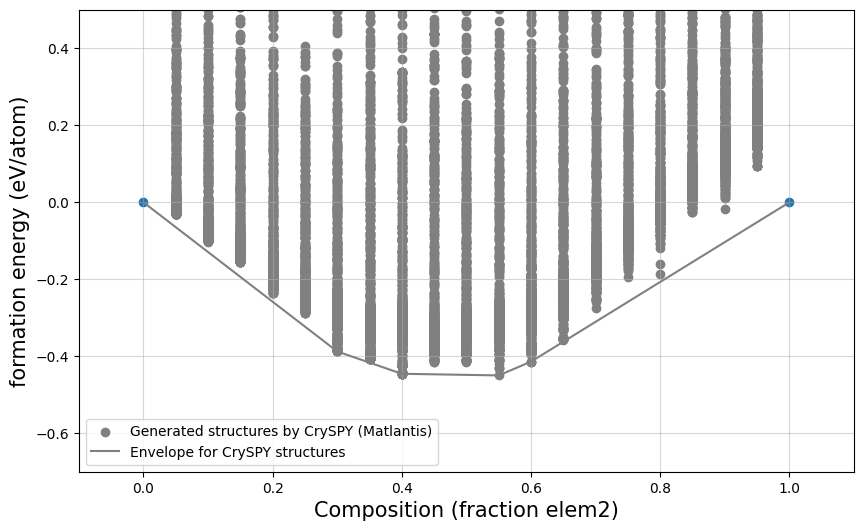

In [3]:
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0)
shift_energies = estimator.get_shift_energy_table()

# setting
elem1 = "Ca"
elem2 = "Si"
base_dir = os.getcwd() + "/output/Ca-Si-gen5-free"
# If you want to compare the results with the data in Materials Project, set this true, or false if not.
show_known_materials = False

os.environ["MP_API_KEY"] = "A3Q66Y507iL8pldSe4HYIgJMQzUKSfvR" # your API of pymatgen

binary = query(elem1+"-"+elem2)
ele1 = query(elem1)
ele2 = query(elem2)
base_energy_mp_e1, base_energy_matlantis_e1 = get_base_energy(ele1)
base_energy_mp_e2, base_energy_matlantis_e2 = get_base_energy(ele2)

mp_ene_lst, matlantis_ene_lst, cryspy_ene_lst, comp_list = [], [], [], []
comp_dir = [subdir for subdir in sorted(os.listdir(base_dir)) if "comp" in subdir]
for sub_dir in comp_dir:
    cryspy_in_path = os.path.join(base_dir, sub_dir, 'cryspy.in')
    energy_path = os.path.join(base_dir, sub_dir, 'data', 'cryspy_rslt_energy_asc')
    
    n_ele1, n_ele2 = read_natom(cryspy_in_path)
    
    r1, r2 = n_ele1 / (n_ele1 + n_ele2), n_ele2 / (n_ele1 + n_ele2)
    ref_matlantis_energy = base_energy_matlantis_e1 * r1 + base_energy_matlantis_e2 * r2
    total_shift_energy = get_shift_energy(elem1, elem2, n_ele1, n_ele2)
    energy_lst = get_cryspy_data(energy_path, total_shift_energy, ref_matlantis_energy)
    
    cryspy_ene_lst.append(energy_lst)
    comp_list.append(r2)

# 2. show energies for known materials by matlantis
comp_list_ = []
if show_known_materials:
    for mp_data in binary:
        mp_ene_lst.append(mp_data["formation_energy_per_atom"])
        n_ele1_, n_ele2_ = mp_data["composition"].values()
        r1_, r2_ = n_ele1_ / (n_ele1_ + n_ele2_), n_ele2_ / (n_ele1_ + n_ele2_)
        comp_list_.append(r2_)

plot_convex_full(base_dir, cryspy_ene_lst, comp_list, comp_list_, 
                 materials_project_energy=mp_ene_lst, show_known_materials=show_known_materials,)